In [1]:
import json
import os
from typing import Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
GROUP_MAP = {
    "detectable_format:number_bullet_lists": "bullet_lists",
    "length_constraints:number_words": "length_constraints",
    "length_constraints:number_sentences": "length_constraints",
    "length_constraints:number_paragraphs": "length_constraints",
    "keywords:forbidden_words": "keywords",
    "keywords:existence": "keywords",
    "change_case:english_capital": "change_case",
    "change_case:english_lowercase": "change_case",
    "detectable_format:json_format": "json_format",
    "startend:quotation": "wrapping",
    "detectable_format:title": "wrapping",
    "combination:repeat_prompt": "startend",
    "startend:end_checker": "startend",
}
GROUP_MAP = {k.replace(':', '_'): v for k, v in GROUP_MAP.items()}

GROUP_MAP_CEQ = {
    "change_case:english_capital": "change_case",
    "change_case:english_lowercase": "change_case",
    "detectable_format:json_format": "json_format",
    "startend:quotation": "wrapping",
    "detectable_format:title": "wrapping",
    "combination:repeat_prompt": "startend",
    "startend:end_checker": "startend",
}
GROUP_MAP_CEQ = {k.replace(':', '_'): v for k, v in GROUP_MAP_CEQ.items()}

GROUP_MAP_CW = {
    "detectable_format:number_bullet_lists": "bullet_lists",
    "length_constraints:number_words": "length_constraints",
    "length_constraints:number_sentences": "length_constraints",
    "length_constraints:number_paragraphs": "length_constraints",
    "keywords:forbidden_words": "keywords",
    "keywords:existence": "keywords",
}
GROUP_MAP_CW = {k.replace(':', '_'): v for k, v in GROUP_MAP_CW.items()}


In [3]:
def get_rule_eval_jsonl(model_name:str, audio_task:str, response_task:str, IF_task:str, data_dir:str="model_responses") -> dict[int, dict[str, Any]]:
    IF_task = IF_task.replace(":", "_")
    file_dir = os.path.join(data_dir, model_name, audio_task, response_task, IF_task, "reports")
    files = os.listdir(file_dir)
    files = [f for f in files if f.startswith("rule_eval@output_") and f.endswith(".jsonl")]
    results = {}
    for file_name in files:
        file_path = os.path.join(file_dir, file_name)
        k = file_name.split("@output_")[-1].split("-shot")[0]
        k = int(k)
        results[k] = []
        with open(file_path, 'r') as f:
            for line in f:
                results[k].append(json.loads(line))
    if len(results) != 9:
        print(f"Warning: Expected 9 shot levels, but got {len(results)} in {file_dir}")
    return results

In [4]:
def createDFfromRuleEvalResults(results:dict[int, dict[str, Any]], response_task:str, performance_metric:str) -> pd.DataFrame:
    d = {"IF_task": [], "shot_level": [], "n": []}
    response_task = response_task.lower()
    if response_task == "creative_writing":
        d["if_rate"] = []
    elif response_task == "closed_ended_questions":
        d["if_rate_strict"] = []
        d["if_rate_loose"] = []
        d["mean_performance"] = []
    elif response_task == "chain_of_thoughts":
        raise NotImplementedError("Chain of thoughts not implemented yet.")
    else:
        raise ValueError(f"Unknown response task: {response_task}")

    for k, v in results.items():
        for shot_level, evaluations in v.items():
            n = len(evaluations)
            d["n"].append(n)
            d["IF_task"].append(k)
            d["shot_level"].append(shot_level)

            if response_task == "creative_writing":
                follow_flags = [eval['follow_all_instructions'] for eval in evaluations]
                d["if_rate"].append(np.mean(follow_flags))
            elif response_task == "closed_ended_questions":
                performance_scores = [eval[performance_metric] for eval in evaluations] if performance_metric in evaluations[0] else None
                strict_follow_flags = [eval['strict_follow_all_instructions'] for eval in evaluations]
                loose_follow_flags = [eval['loose_follow_all_instructions'] for eval in evaluations]
                mean_performance = np.mean(performance_scores) if performance_scores is not None else None
                if_rate_strict = np.mean(strict_follow_flags)
                if_rate_loose = np.mean(loose_follow_flags)
                d["if_rate_strict"].append(if_rate_strict)
                d["if_rate_loose"].append(if_rate_loose)
                d["mean_performance"].append(mean_performance)

    return pd.DataFrame(d)

In [5]:
def eval(model_name:str, response_task:str="closed_ended_questions", to_csv:bool=True):
    response_task = response_task.lower()
    d_df = {}
    for audio_task, performance_metric in zip(["ASR", "GR", "SER"], ["wer", "answer_correct", "answer_correct"]):
        IF_tasks = os.listdir(os.path.join("model_responses", model_name, audio_task, response_task))
        IF_tasks = [ft for ft in IF_tasks if ft in GROUP_MAP.keys()]
        results = {}
        for IF_task in IF_tasks:
            results[IF_task] = get_rule_eval_jsonl(model_name, audio_task, response_task, IF_task)
        d_df[audio_task] = createDFfromRuleEvalResults(results, response_task, performance_metric)

    if to_csv:
        for audio_task, df in d_df.items():
            fn = os.path.join("./analysis/tmp", f"{model_name}_{audio_task}_{response_task}_summary.csv")
            print(f"Saving summary to {fn}")
            df.to_csv(fn, index=False)

    return d_df

# closed_ended_questions

In [23]:
response_task = "closed_ended_questions"
d_df = {}
for model_name in ["qwen", "qwen2", "desta2_5", "blsp-emo"]:
    print(f"------------ {model_name} ------------")
    d_df[model_name] = eval(model_name, response_task=response_task, to_csv=True)

------------ qwen ------------
Saving summary to ./analysis/tmp/qwen_ASR_closed_ended_questions_summary.csv
Saving summary to ./analysis/tmp/qwen_GR_closed_ended_questions_summary.csv
Saving summary to ./analysis/tmp/qwen_SER_closed_ended_questions_summary.csv
------------ qwen2 ------------
Saving summary to ./analysis/tmp/qwen2_ASR_closed_ended_questions_summary.csv
Saving summary to ./analysis/tmp/qwen2_GR_closed_ended_questions_summary.csv
Saving summary to ./analysis/tmp/qwen2_SER_closed_ended_questions_summary.csv
------------ desta2_5 ------------
Saving summary to ./analysis/tmp/desta2_5_ASR_closed_ended_questions_summary.csv
Saving summary to ./analysis/tmp/desta2_5_GR_closed_ended_questions_summary.csv
Saving summary to ./analysis/tmp/desta2_5_SER_closed_ended_questions_summary.csv
------------ blsp-emo ------------
Saving summary to ./analysis/tmp/blsp-emo_ASR_closed_ended_questions_summary.csv
Saving summary to ./analysis/tmp/blsp-emo_GR_closed_ended_questions_summary.csv
S

In [24]:
model_order = ["qwen", "qwen2", "desta2_5", "blsp-emo"]

# put "other" last; keep the rest in a deterministic order
group_order = []
for v in GROUP_MAP_CEQ.values():
    if v not in group_order and v != "other":
        group_order.append(v)

df_audio_task = {}
fn = os.path.join("./analysis", f"summary_ceq.xlsx")

with pd.ExcelWriter(fn, engine="openpyxl") as writer:
    for audio_task in ["ASR", "GR", "SER"]:
        dfs = []
        for model_name in model_order:
            df = d_df[model_name][audio_task].copy()

            df["model"] = model_name
            df["IF_task_group"] = df["IF_task"].map(GROUP_MAP_CEQ)

            df = df[[
                "IF_task_group", "IF_task", "n", "model",
                "shot_level", "if_rate_strict", "if_rate_loose", "mean_performance"
            ]]
            dfs.append(df)

        df_all = pd.concat(dfs, ignore_index=True)

        # --- ordered categoricals for deterministic sorting ---
        # shot_level: if it's numeric, this works; if it's strings like "0-shot", see note below
        shot_order = sorted(df_all["shot_level"].dropna().unique())
        df_all["shot_level"] = pd.Categorical(df_all["shot_level"], categories=shot_order, ordered=True)

        df_all["IF_task_group"] = pd.Categorical(df_all["IF_task_group"], categories=group_order, ordered=True)
        df_all["model"] = pd.Categorical(df_all["model"], categories=model_order, ordered=True)

        df_all_compare_shots = df_all.sort_values(
            by=["IF_task_group", "IF_task", "model"],
            ascending=[True, True, True],
            kind="mergesort",
        )

        df_all = df_all.sort_values(
            by=["shot_level", "IF_task_group", "IF_task", "model"],
            ascending=[True, True, True, True],
            kind="mergesort",
        )

        df_all_grouped = df_all.groupby(["shot_level", "IF_task_group", "model"], observed=False).mean(numeric_only=True).reset_index()
        df_all_compare_shots_grouped = df_all_compare_shots.groupby(["IF_task_group", "model", "shot_level"], observed=False).mean(numeric_only=True).reset_index()

        df_all.to_excel(writer, sheet_name=audio_task, index=False)
        df_all_grouped.to_excel(writer, sheet_name=f"{audio_task}_grouped", index=False)
        df_all_compare_shots.to_excel(writer, sheet_name=f"{audio_task}_compare_shots", index=False)
        df_all_compare_shots_grouped.to_excel(writer, sheet_name=f"{audio_task}_compare_shots_grouped", index=False)

        df_audio_task[audio_task] = df_all
        df_audio_task[f"{audio_task}_grouped"] = df_all_grouped
        df_audio_task[f"{audio_task}_compare_shots"] = df_all_compare_shots
        df_audio_task[f"{audio_task}_compare_shots_grouped"] = df_all_compare_shots_grouped

print(f"Saving combined summary to {fn}")


Saving combined summary to ./analysis/summary_ceq.xlsx


In [25]:
df_audio_task_ceq = df_audio_task.copy()

In [26]:
def get_pivot_table(
    df:pd.DataFrame,
    shot_level:int,
    index:str='model',
    columns:str='IF_task_group',
    values:str='mean_performance'
) -> pd.DataFrame:
    df_shot = df[df['shot_level'] == shot_level]
    return df_shot.pivot_table(index=index, columns=columns, values=values, aggfunc='mean', observed=False)

In [34]:
def plot_metric_by_shot_level(
    df_audio_task:dict[str, pd.DataFrame],
    audio_task: str,
    metric_name:str='mean_performance'
) -> None:
    tmp = df_audio_task[f"{audio_task}_grouped"]
    for IF_task_group in tmp['IF_task_group'].unique():
        plt.figure()
        for model in model_order:
            tmp_model = tmp[(tmp['IF_task_group'] == IF_task_group) & (tmp['model'] == model)]
            plt.plot(tmp_model['shot_level'], tmp_model[metric_name], marker='o', label=model)
        plt.title(f'Performance by Model - {audio_task} ({IF_task_group})')
        plt.xlabel('Shot Level')
        plt.ylabel(metric_name)
        plt.grid(linestyle='--', alpha=0.7)
        plt.legend()
        plt.show()

In [27]:
get_pivot_table(df_audio_task_ceq["SER_grouped"], shot_level=0)

IF_task_group,change_case,json_format,wrapping,startend
model,,,,
qwen,0.40,0.30,0.34,0.40
qwen2,0.48,0.60,0.34,0.46
desta2_5,0.68,0.54,0.36,0.70
blsp-emo,0.44,0.66,0.44,0.52


In [28]:
get_pivot_table(df_audio_task_ceq["SER_grouped"], values="if_rate_strict", shot_level=0)

IF_task_group,change_case,json_format,wrapping,startend
model,,,,
qwen,0.00,0.30,0.00,0.20
qwen2,0.58,0.00,0.24,0.68
desta2_5,1.00,0.96,0.90,0.96
blsp-emo,0.74,1.00,0.44,0.58


In [29]:
get_pivot_table(df_audio_task_ceq["SER_grouped"], shot_level=1)

IF_task_group,change_case,json_format,wrapping,startend
model,,,,
qwen,0.38,0.36,0.36,0.48
qwen2,0.48,0.64,0.56,0.58
desta2_5,0.50,0.60,0.32,0.60
blsp-emo,0.64,0.70,0.44,0.62


In [66]:
get_pivot_table(df_audio_task["SER_grouped"], shot_level=8)

IF_task_group,change_case,json_format,wrapping,startend
model,,,,
qwen,0.24,0.32,0.26,0.24
qwen2,0.48,0.62,0.54,0.42
desta2_5,0.58,0.38,0.28,0.28
blsp-emo,0.68,0.66,0.44,0.40


### Plots

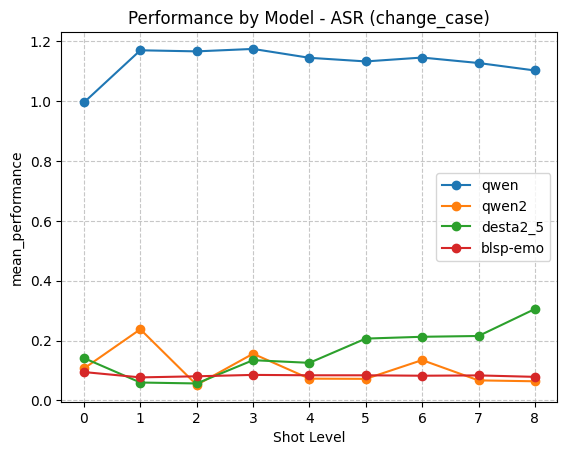

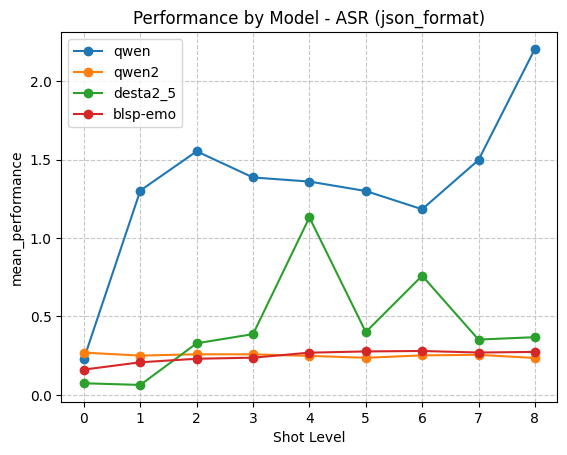

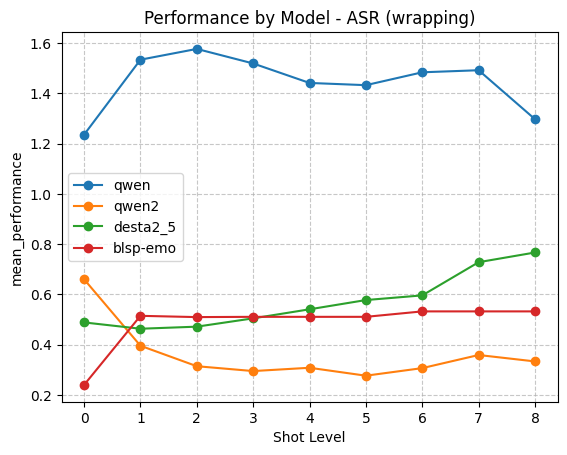

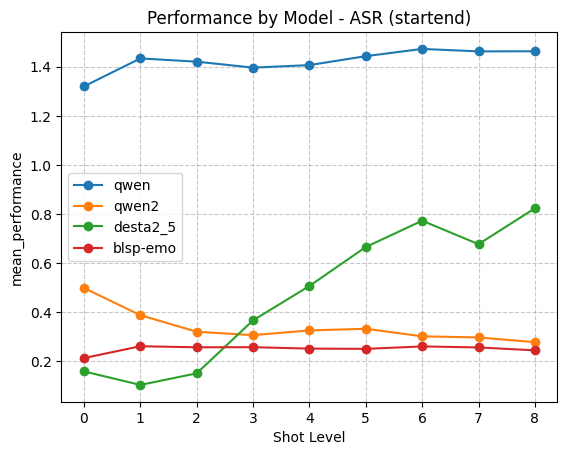

In [19]:
plot_metric_by_shot_level(df_audio_task, audio_task="ASR", metric_name='mean_performance')

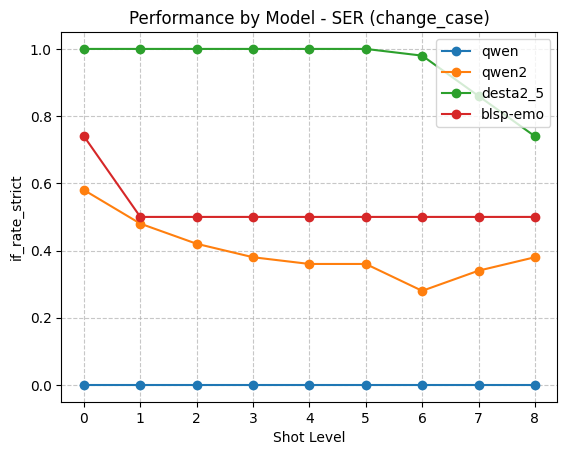

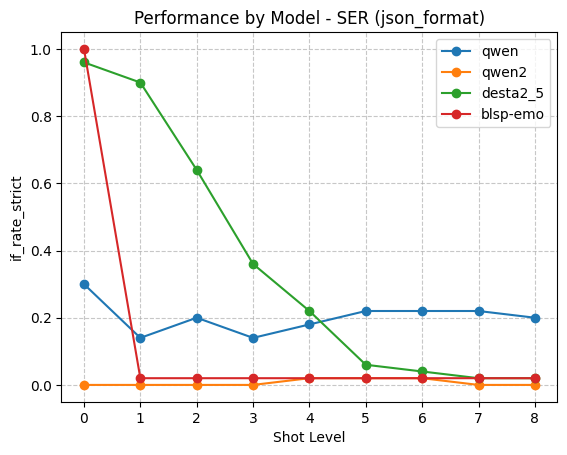

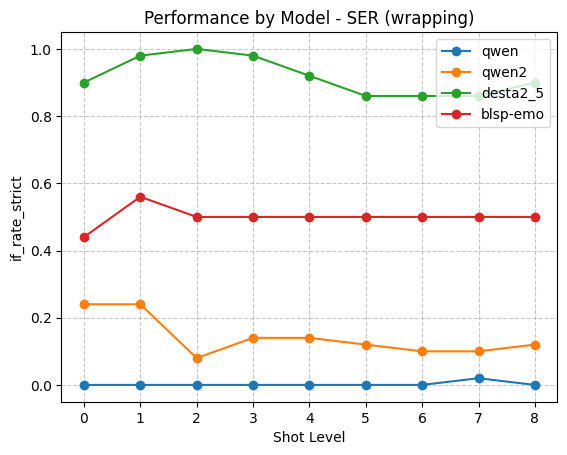

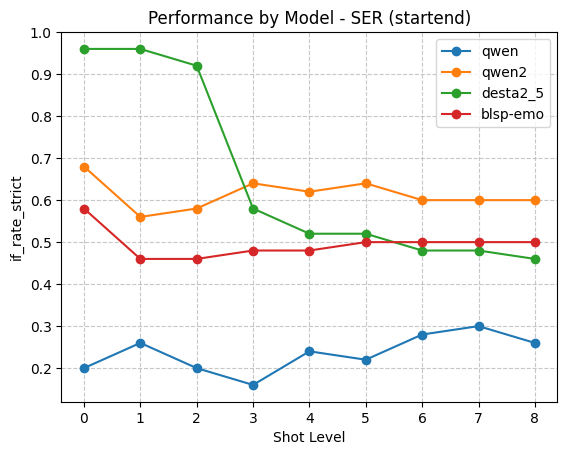

In [87]:
plot_metric_by_shot_level(df_audio_task, audio_task="SER", metric_name='if_rate_strict')

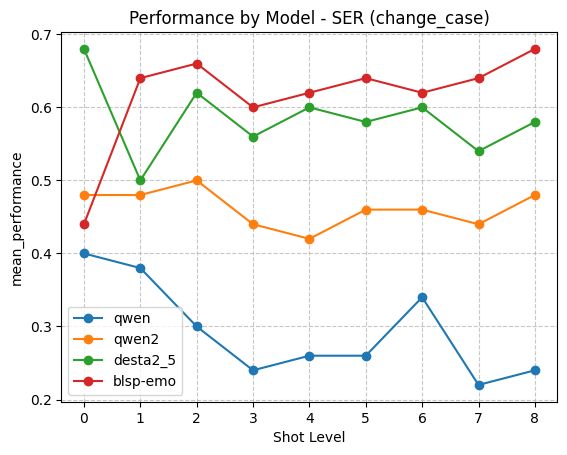

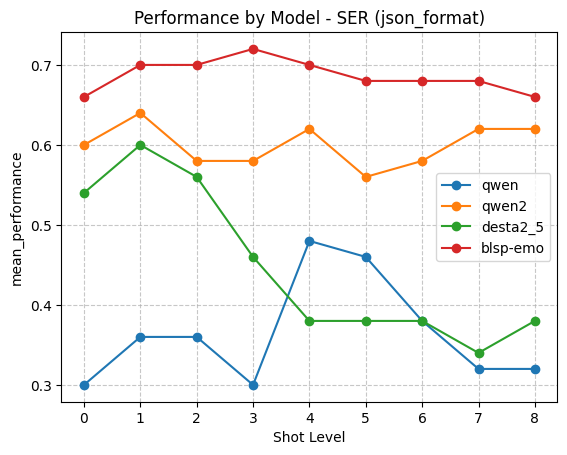

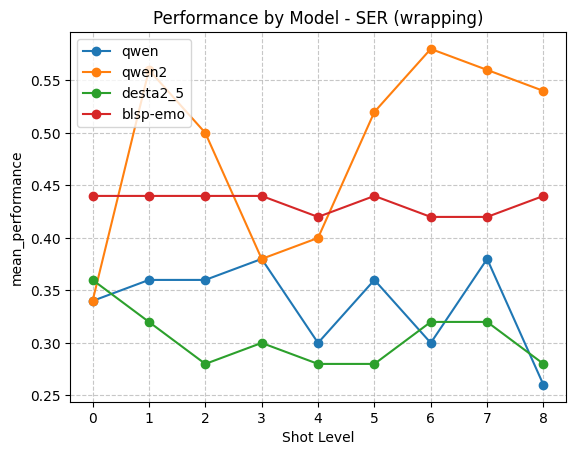

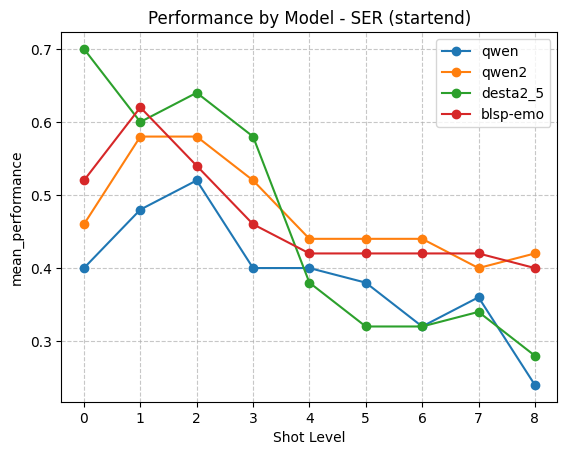

In [84]:
plot_metric_by_shot_level(df_audio_task, audio_task="SER", metric_name='mean_performance')

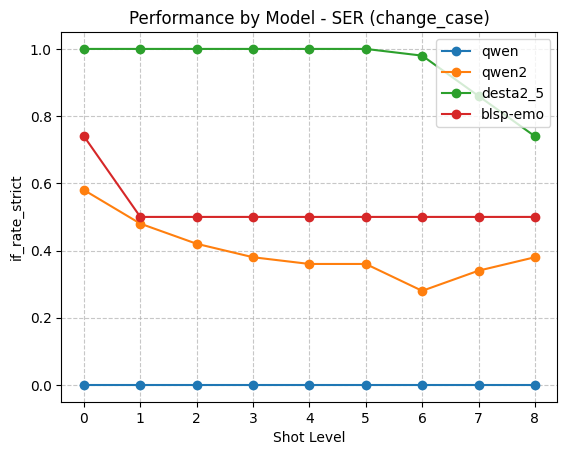

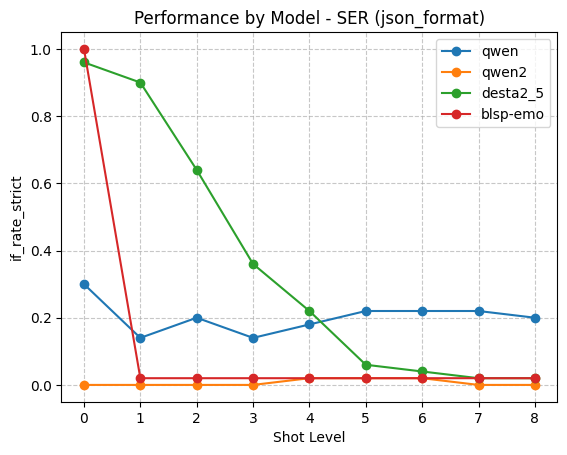

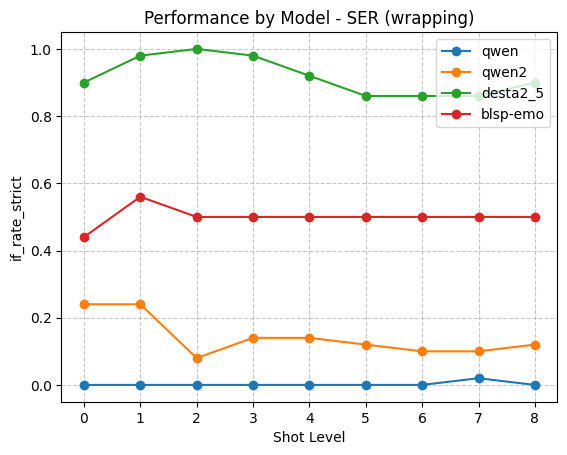

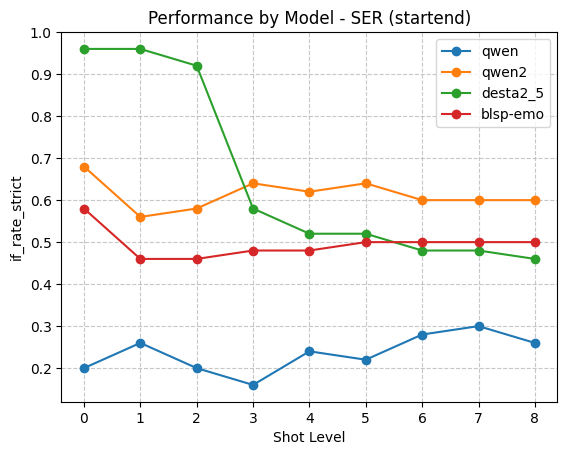

In [85]:
plot_metric_by_shot_level(df_audio_task, audio_task="SER", metric_name='if_rate_strict')

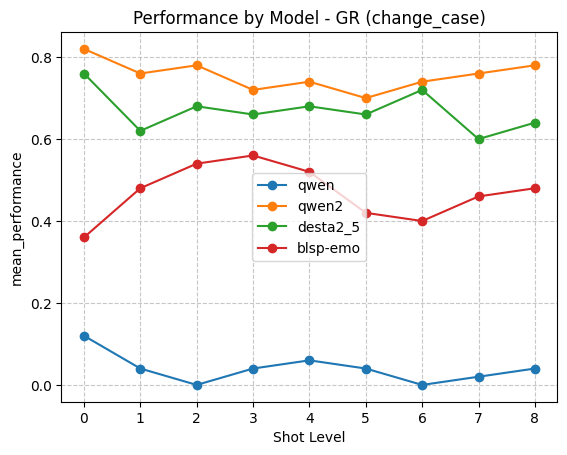

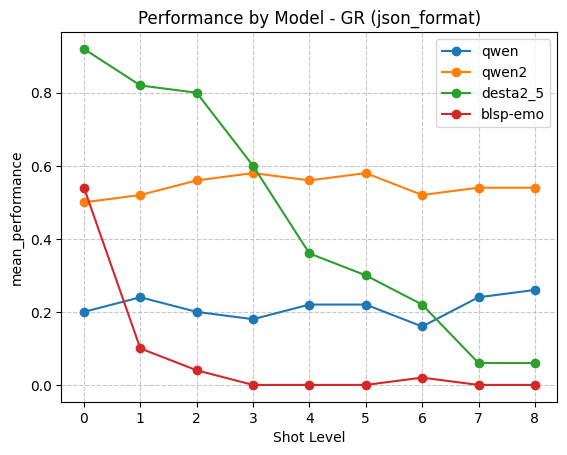

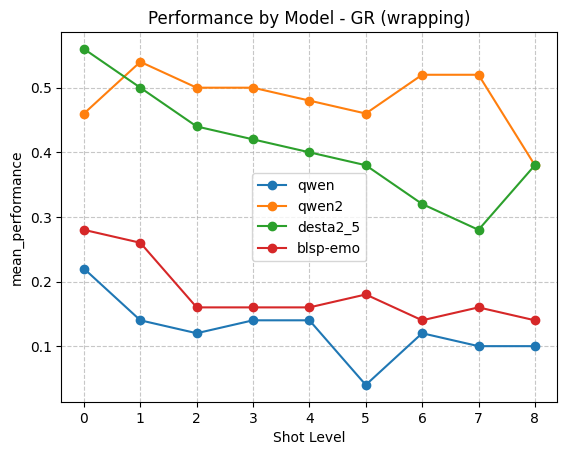

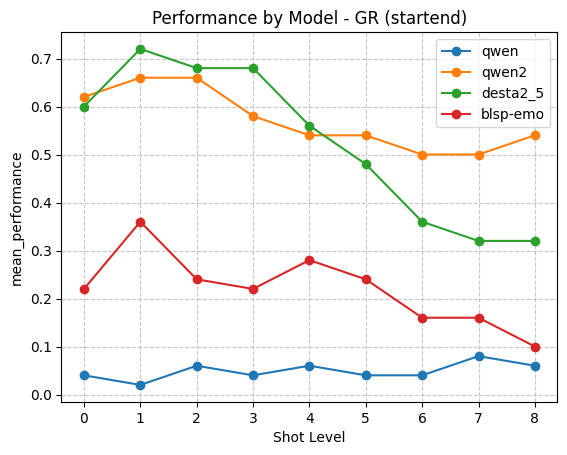

In [88]:
plot_metric_by_shot_level(df_audio_task, audio_task="GR", metric_name='mean_performance')

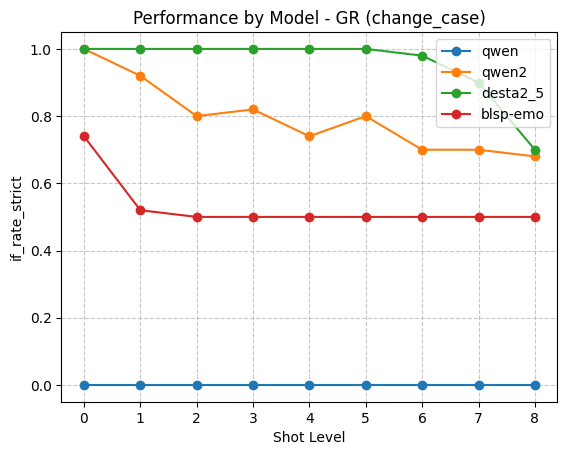

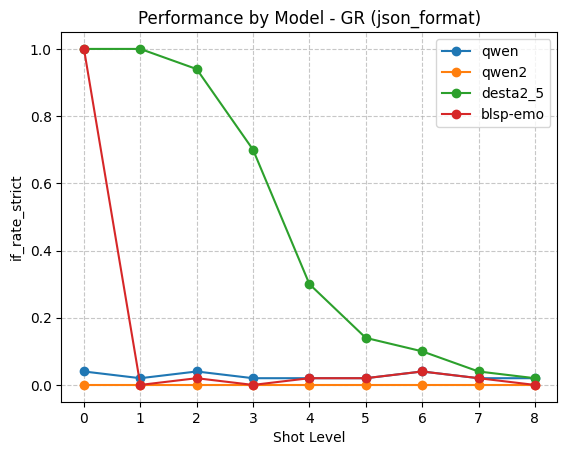

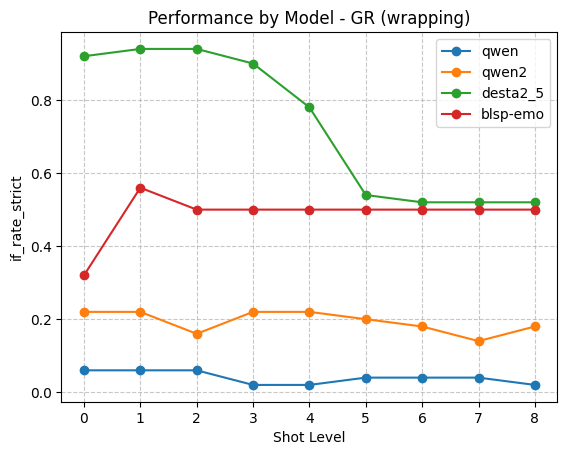

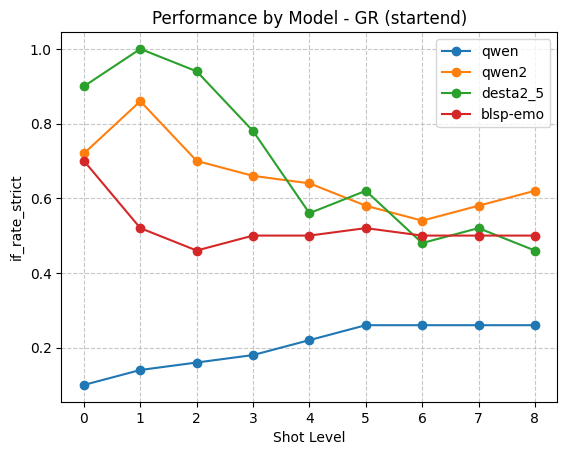

In [90]:
plot_metric_by_shot_level(df_audio_task, audio_task="GR", metric_name='if_rate_strict')

# creative_writing

In [31]:
response_task = "creative_writing"
d_df = {}
for model_name in ["qwen", "qwen2", "desta2_5", "blsp-emo"]:
    print(f"------------ {model_name} ------------")
    d_df[model_name] = eval(model_name, response_task=response_task, to_csv=True)

------------ qwen ------------
Saving summary to ./analysis/tmp/qwen_ASR_creative_writing_summary.csv
Saving summary to ./analysis/tmp/qwen_GR_creative_writing_summary.csv
Saving summary to ./analysis/tmp/qwen_SER_creative_writing_summary.csv
------------ qwen2 ------------
Saving summary to ./analysis/tmp/qwen2_ASR_creative_writing_summary.csv
Saving summary to ./analysis/tmp/qwen2_GR_creative_writing_summary.csv
Saving summary to ./analysis/tmp/qwen2_SER_creative_writing_summary.csv
------------ desta2_5 ------------
Saving summary to ./analysis/tmp/desta2_5_ASR_creative_writing_summary.csv
Saving summary to ./analysis/tmp/desta2_5_GR_creative_writing_summary.csv
Saving summary to ./analysis/tmp/desta2_5_SER_creative_writing_summary.csv
------------ blsp-emo ------------
Saving summary to ./analysis/tmp/blsp-emo_ASR_creative_writing_summary.csv
Saving summary to ./analysis/tmp/blsp-emo_GR_creative_writing_summary.csv
Saving summary to ./analysis/tmp/blsp-emo_SER_creative_writing_summ

In [32]:
model_order = ["qwen", "qwen2", "desta2_5", "blsp-emo"]

# put "other" last; keep the rest in a deterministic order
group_order = []
for v in GROUP_MAP_CW.values():
    if v not in group_order and v != "other":
        group_order.append(v)

df_audio_task = {}
fn = os.path.join("./analysis", f"summary_cw.xlsx")

with pd.ExcelWriter(fn, engine="openpyxl") as writer:
    for audio_task in ["ASR", "GR", "SER"]:
        dfs = []
        for model_name in model_order:
            df = d_df[model_name][audio_task].copy()

            df["model"] = model_name
            df["IF_task_group"] = df["IF_task"].map(GROUP_MAP_CW)

            df = df[[
                "IF_task_group", "IF_task", "n", "model",
                "shot_level", "if_rate"
            ]]
            dfs.append(df)

        df_all = pd.concat(dfs, ignore_index=True)

        # --- ordered categoricals for deterministic sorting ---
        # shot_level: if it's numeric, this works; if it's strings like "0-shot", see note below
        shot_order = sorted(df_all["shot_level"].dropna().unique())
        df_all["shot_level"] = pd.Categorical(df_all["shot_level"], categories=shot_order, ordered=True)

        df_all["IF_task_group"] = pd.Categorical(df_all["IF_task_group"], categories=group_order, ordered=True)
        df_all["model"] = pd.Categorical(df_all["model"], categories=model_order, ordered=True)

        df_all_compare_shots = df_all.sort_values(
            by=["IF_task_group", "IF_task", "model"],
            ascending=[True, True, True],
            kind="mergesort",
        )

        df_all = df_all.sort_values(
            by=["shot_level", "IF_task_group", "IF_task", "model"],
            ascending=[True, True, True, True],
            kind="mergesort",
        )

        df_all_grouped = df_all.groupby(["shot_level", "IF_task_group", "model"], observed=False).mean(numeric_only=True).reset_index()
        df_all_compare_shots_grouped = df_all_compare_shots.groupby(["IF_task_group", "model", "shot_level"], observed=False).mean(numeric_only=True).reset_index()

        df_all.to_excel(writer, sheet_name=audio_task, index=False)
        df_all_grouped.to_excel(writer, sheet_name=f"{audio_task}_grouped", index=False)
        df_all_compare_shots.to_excel(writer, sheet_name=f"{audio_task}_compare_shots", index=False)
        df_all_compare_shots_grouped.to_excel(writer, sheet_name=f"{audio_task}_compare_shots_grouped", index=False)

        df_audio_task[audio_task] = df_all
        df_audio_task[f"{audio_task}_grouped"] = df_all_grouped
        df_audio_task[f"{audio_task}_compare_shots"] = df_all_compare_shots
        df_audio_task[f"{audio_task}_compare_shots_grouped"] = df_all_compare_shots_grouped

print(f"Saving combined summary to {fn}")


Saving combined summary to ./analysis/summary_cw.xlsx


In [33]:
df_audio_task_cw = df_audio_task.copy()

In [ ]:
plot_metric_by_shot_level(df_audio_task_cw, audio_task="ASR", metric_name='if_rate')

In [38]:
fn = '/tmp2/jayliao/MAI-2025-Fall-Final-Project-Group-3/model_responses/desta2_5/SER/closed_ended_questions/startend_quotation/reports/rule_eval@output_0-shot_20251214-084348.jsonl'
data = []
with open(fn, 'r') as f:
    for line in f:
        data.append(json.loads(line))
data = pd.DataFrame(data)

In [39]:
data

,id,audio_filepath,textual_audio,instruction,dataset,metric,instruction_id_list,kwargs,label,messages,response,follow_instruction_list,follow_all_instructions,strict_follow_instruction_list,strict_follow_all_instructions,loose_follow_instruction_list,loose_follow_all_instructions,answer_correct
0,300,Speech_emotion_recognition/Ses05F_script02_1_M...,[00:00:00 - 00:00:09] Think about people in Ka...,"Listen carefully to the tone, pitch, pace, and...",Speech_emotion_recognition,accuracy,[startend:quotation],[{}],happy,"[{""role"": ""system"", ""content"": ""You are a help...","""Happy""",[True],True,[True],True,[True],True,False
1,301,Speech_emotion_recognition/Ses05F_impro04_F008...,[00:00:00 - 00:00:06] I still can't live on 67...,"Observe the tone, pitch, pacing, and inflectio...",Speech_emotion_recognition,accuracy,[startend:quotation],[{}],angry,"[{""role"": ""system"", ""content"": ""You are a help...","""Based on the audio input, I would categorize ...",[True],True,[True],True,[True],True,False
2,302,Speech_emotion_recognition/Ses05M_impro07_M009...,[00:00:00 - 00:00:05] I worked really hard. I'...,"Pay close attention to the speakers tone, pitc...",Speech_emotion_recognition,accuracy,[startend:quotation],[{}],happy,"[{""role"": ""system"", ""content"": ""You are a help...","""Neutral""",[True],True,[True],True,[True],True,False
3,303,Speech_emotion_recognition/Ses05F_script01_3_M...,"[00:00:00 - 00:00:03] I want you now, Annie.(G...","Listen to the tone, pitch, and rate of speech,...",Speech_emotion_recognition,accuracy,[startend:quotation],[{}],happy,"[{""role"": ""system"", ""content"": ""You are a help...","""happy""",[True],True,[True],True,[True],True,False
4,304,Speech_emotion_recognition/Ses05M_impro07_F009...,"[00:00:00 - 00:00:02] Yeah, that's awesome.(Ge...","Listen to tone, pitch, pace, and stress in the...",Speech_emotion_recognition,accuracy,[startend:quotation],[{}],happy,"[{""role"": ""system"", ""content"": ""You are a help...","""neutral""",[True],True,[True],True,[True],True,False
5,305,Speech_emotion_recognition/Ses05F_script01_3_M...,[00:00:00 - 00:00:12] You feel it's wrong here...,"Listen closely to the tone, pitch, and tempo o...",Speech_emotion_recognition,accuracy,[startend:quotation],[{}],happy,"[{""role"": ""system"", ""content"": ""You are a help...","""Neutral""",[True],True,[True],True,[True],True,False
6,306,Speech_emotion_recognition/Ses05F_script01_1_M...,[00:00:00 - 00:00:04] business the business th...,"Listen to the tone, pace, and pitch of the spe...",Speech_emotion_recognition,accuracy,[startend:quotation],[{}],angry,"[{""role"": ""system"", ""content"": ""You are a help...","""Angry""",[True],True,[True],True,[True],True,False
7,307,Speech_emotion_recognition/Ses05M_script03_2_F...,[00:00:00 - 00:00:03] It's becoming a habit wi...,"Listen to the tone, pitch, and pace of the spe...",Speech_emotion_recognition,accuracy,[startend:quotation],[{}],neutral,"[{""role"": ""system"", ""content"": ""You are a help...","""Neutral""",[True],True,[True],True,[True],True,False
8,308,Speech_emotion_recognition/Ses05F_impro08_M005...,[00:00:00 - 00:00:09] Can you like talk to som...,Identify the primary emotion being conveyed in...,Speech_emotion_recognition,accuracy,[startend:quotation],[{}],angry,"[{""role"": ""system"", ""content"": ""You are a help...","""Angry""",[True],True,[True],True,[True],True,False
9,309,Speech_emotion_recognition/Ses05F_impro05_M025...,"[00:00:00 - 00:00:05] Well, we're talking abou...","Listen to the tone, pace, volume, and pitch of...",Speech_emotion_recognition,accuracy,[startend:quotation],[{}],neutral,"[{""role"": ""system"", ""content"": ""You are a help...","""Neutral""",[True],True,[True],True,[True],True,False
